# Using Auxillary Data To Reduce Forgetting
In this notebook we will explore how we can use auxillary data to reduce forgetting.

In [18]:
!pip install pandas
!pip install tensorboard
!pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/b4/c2/f74e0deb26379aead0956a6ecf9acd4587debba0c7abe4bd8fe53fe04ec2/matplotlib-3.7.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/32/c8/aa9e87941002150b1a8e7087e48da1c76290268b9fdfa3034a98a5806198/contourpy-1.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/d3/e2/0dc07c946b98a036b25b97899bf38d51aef24f793b80ac686f07f817b7ac/fonttools-4.42.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Obtaining de

In [19]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# To create csv files from tensorboard logs
def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

def get_scalar_tags(path):
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    return ea.Tags()

## Using a labelled stratified subset of the data
In these experiments we selected the auxillary data as a subset of our CL benchmark, specifically, we select it randomly in a stratified manner (ie. our subset has an equal number of samples from every class). 

Let's first investigate how varying the percentage of the total dataset that we use as auxillary data affects the performance of the model on the split-CIFAR10 with 5 tasks:

In [27]:
# Let's create a list of all the experiments we want to compare:
experiments = [
    "percent_0.25_ratio_0.25_lr_0.1",
    "percent_0.5_ratio_0.5_lr_0.1",
    "percent_0.75_ratio_0.75_lr_0.1"
]
base_str = "log/SplitCIFAR10/VGG16/SGD/fixed_replay_stratify/"
experiments = [base_str + exp for exp in experiments]

# Let's first get the data from our tensorboard logs:
data = []
for exp in experiments:
    data.append(parse_tensorboard(exp, [
        "Top1_Acc_MB/train_phase/train_stream/Task000", 
        "Top1_ClassAcc_MB/train_phase/train_stream/Task000/0",
        "Top1_ClassAcc_MB/train_phase/train_stream/Task000/1",
        "Top1_ClassAcc_MB/train_phase/train_stream/Task000/2",
        "Top1_ClassAcc_MB/train_phase/train_stream/Task000/3",
        "Top1_ClassAcc_MB/train_phase/train_stream/Task000/4",
        "Top1_ClassAcc_MB/train_phase/train_stream/Task000/5",
        "Top1_ClassAcc_MB/train_phase/train_stream/Task000/6",
        "Top1_ClassAcc_MB/train_phase/train_stream/Task000/7",
        "Top1_ClassAcc_MB/train_phase/train_stream/Task000/8",
        "Top1_ClassAcc_MB/train_phase/train_stream/Task000/9",
    ]))

# Let's now plot a graph for the accuracy and loss over training for each experiment:
fig, ax = plt.subplots(len(experiments), 1, figsize=(10, 10))
for i, exp in enumerate(experiments):
    ax[i,0].plot(data[i]["Top1_Acc_MB/train_phase/train_stream/Task000"], label="Accuracy")
    # ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/0"], label="Class 0")
    # ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/1"], label="Class 1")
    # ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/2"], label="Class 2")
    # ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/3"], label="Class 3")
    # ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/4"], label="Class 4")
    # ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/5"], label="Class 5")
    # ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/6"], label="Class 6")
    # ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/7"], label="Class 7")
    # ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/8"], label="Class 8")
    # ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/9"], label="Class 9")
    ax[i,0].set_title(exp)
    ax[i,0].set_xlabel("Minibatch")
    ax[i,0].set_ylabel("Accuracy")
    ax[i,0].legend()


DirectoryDeletedError: Directory log/SplitCIFAR10/VGG16/SGD/fixed_replay_stratify/percent_0.25_ratio_0.25_lr_0.1 has been permanently deleted

Let's now plot the accuracy for each class so we can see if forgetting is occuring for any of the classes. 

TypeError: 'Axes' object is not subscriptable

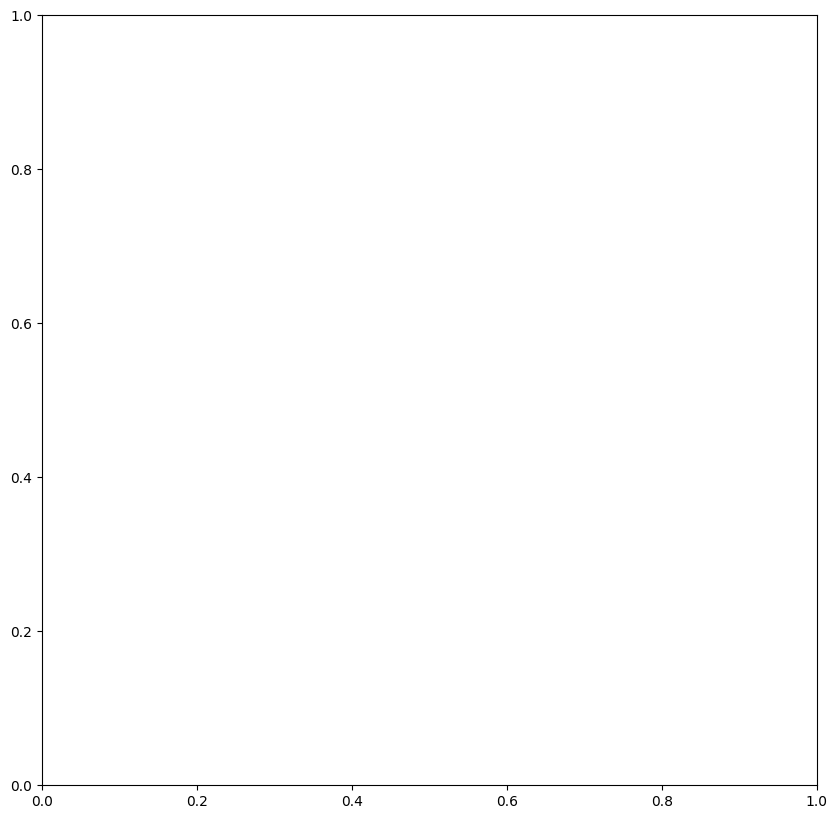

In [26]:
# Let's now plot a graph for the accuracy and loss over training for each experiment:
fig, ax = plt.subplots(len(experiments), 1, figsize=(10, 10))
for i, exp in enumerate(experiments):
    ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/0"], label="Class 0")
    ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/1"], label="Class 1")
    ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/2"], label="Class 2")
    ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/3"], label="Class 3")
    ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/4"], label="Class 4")
    ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/5"], label="Class 5")
    ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/6"], label="Class 6")
    ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/7"], label="Class 7")
    ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/8"], label="Class 8")
    ax[i].plot(data[i]["Top1_ClassAcc_MB/train_phase/train_stream/Task000/9"], label="Class 9")
    ax[i,0].set_title(exp)
    ax[i,0].set_xlabel("Minibatch")
    ax[i,0].set_ylabel("Accuracy")
    ax[i,0].legend()